In [2]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

# 什么是滤波

滤波的概念主要出自信号学领域，指的是过滤我们不感兴趣的信号频段。最早使用滤波技术的，应该最早出自无线电领域，通过可调电容来完成滤波。大家比较熟悉的一种物理滤波应用，就是收音机了，学习数字图像领域的朋友倒是不太需要了解电容对于信号的滤波作用，所以这里也不必过多的展开。

# 空间滤波（Spatial Filtering）

虽然都是滤波，但是在图像领域有两类比较重要的滤波技术，一种是空间滤波，另一种是频域滤波。而对于视频图像分析，则有另外一类被称为时域滤波的技术。不过数字图像处理主要介绍到空间和频率。

在之前的章节里，我已经简单的介绍了一些图像增强技术，你可以简单的理解为对输入的像素$I_i$，套用某个公式或者算法$f_s$，然后得到一个输出$I_o$的过程，写作一个公式的话，就表示为：

$$I_o = I_i \bigodot f_s$$

对像素点的逐点计算，与矩阵概念上的 **哈达玛积(hadamard product)** 很相似。只不过与Hadamard product不一样的地方在于，空间滤波函数通常不是一次性的把全部像素点放入到 $f_s$ 里进行处理，而是每次取出一小块，再逐次地拿到 $f_s$ 处理函数里进行计算。

我在 Wikipedia 上看到一张有意思的动图，它是一个均值滤波函数，左边是原始数据，中间是滤波核，右边则是处理后的结果，它很好的解释了什么是空间滤波，以及空间滤波函数的计算过程。

![在这里插入图片描述](https://img-blog.csdnimg.cn/20201213143831414.gif#pic_center)

你或许已经注意到在这里定义了一个核函数，也就是中间 $3 \times 3$ 的部分，它包含9个值，每个值都是1/9。在原图像进行处理的时候，我们让这个被定义的核函数，依次平滑地扫过每一个点，然后从红框所包含的像素里，分别读取9个像素值，然后和我们定义的核函数相乘，再把每一个结果相加起来，写做数学公式，简单一点，就成了：

$$P_1 \cdot K_1 + P_2 \cdot K_2 + P_3 \cdot K_3 + \cdots + P_9 \cdot K_9 = P_{ij}^{*}$$

这里的K，表示的是每个原始像素对新像素值的贡献值，或者称为权重，而P则是9个不同的像素点的值。

简化一下这个表达过程，于是再次推导出我们的一个通用计算公式：$I_o = I_i \bigodot f_s$ 

而为了表示红框逐像素点处理的过程，在很多教材上你会看到它的这样一个表示方式：

$$I_o = \sum \sum I_{i,j} \bigodot f_s$$

它的核心思想就是，想要得到某种效果的输出矩阵（图像），它是由原始图像，与某种操作共同组合而成，而且这个操作必然需要逐点（逐快）扫描，这个过程有点像你拿放大镜观察物体的过程，而负责处理这个最终像素生成的过程就是所谓的**空间滤波器**了。

这里的 $f_s$ 即空间滤波器的核函数，它可以是某个数学函数，也可以是我们自己用代码实现的具备某种特殊处理方法，比如对于数值大于15的输入一律输出为0。看到这里，你是不是跃跃欲试，想自己开发一种特别的数据处理方法？

尽管不排除可以自己设计某种特殊滤波器的天才，不过通常情况下，我们普通人都会用数学家、或者信号学家发明的一系列工具，用于图像细节增强、降噪，或者提取特征，除了有时会觉得这样做调参很麻烦，但是终归利大于弊。



In [3]:
# 高斯噪声
def add_gaussian_noise(image, mean=0, sigma=25, ratio=0.5):
    noisy_image = image.copy()
    noise = np.random.normal(mean, sigma, image.shape)
    mask = np.random.rand(*image.shape) < ratio
    noisy_image[mask] = np.clip(image[mask] + noise[mask], 0, 255)
    return noisy_image.astype(np.uint8)

# 椒盐噪声
def add_salt_and_pepper_noise(image, salt_prob=0.01, pepper_prob=0.01):
    noisy_image = image.copy()
    salt = np.random.rand(*image.shape) < salt_prob
    pepper = np.random.rand(*image.shape) < pepper_prob
    noisy_image[salt] = 255
    noisy_image[pepper] = 0
    return noisy_image


# 均值滤波器(Mean Filter)

均值滤波器，其核函数经常写成如下的解析式：

$$
K = \frac{1}{K_w \times K_h} \sum f(x, y) \cdot W(x, y)
$$

这里的$K_w$ 和 $K_h$ 表示的是核函数的长和宽，后面表示待处理的部分各像素的贡献权重，并求和。它的实现代码可以简单的写成如下形式

In [4]:
# 均值滤波器
def mean_filter(image, kernel_size=3):
    mean_filtered = cv2.blur(image, (kernel_size, kernel_size))
    return mean_filtered

# 中值滤波器(Median Filter)

与均值滤波器相似，只不过在赋值环节，有所不同。它要求

**首先** 将读取的像素值按照大小进行排序
**然后** 选取排序后中间的数值，或者中间数值的平均

这是一种常用的，用于处理类似椒盐噪音那样，孤点信号的特殊方法。举例来说，对于$3 \times 3$ 滤波核来说，假如读取了一组信号，它是

![在这里插入图片描述](https://img-blog.csdnimg.cn/20210304212053357.png#pic_center)
对数据进行排列后为

$$[0, 2, 3, 3, 4, 6,10,15, 97]$$

那么处理后，中间97的值就应该表示为4
![在这里插入图片描述](https://img-blog.csdnimg.cn/20210304212254743.png#pic_center)

In [5]:
# 中值滤波器
def median_filter(image, kernel_size=3):
    median_filtered = cv2.medianBlur(image, kernel_size)
    return median_filtered

# 高斯滤波器(Gaussian Filter)

高斯滤波器是一种非常常见的空间滤波器，通常用于去除高斯噪声。它使用高斯函数生成一个核，然后将该核与图像卷积，以实现平滑效果。与均值滤波器不同，高斯滤波器会根据距离中心的远近对周围像素赋予不同的权重，使其具有较好的边缘保持效果。

下面是代码示例，其中包括生成带有高斯噪声的图像并使用高斯滤波器去噪的实现。

In [6]:
def gaussian_filter(image, kernel_size=5, sigma=1.5):
    gaussian_filtered = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigmaX=sigma)
    return gaussian_filtered

# 测试用例

生成带噪声图像并应用高斯滤波器去噪。

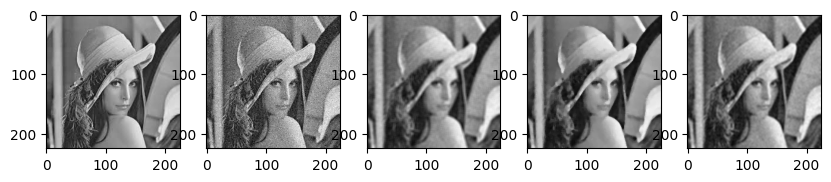

In [7]:
# 加载图像
image = cv2.imread('/opt/images/lena.png', cv2.IMREAD_GRAYSCALE)

# 生成带高斯噪声的图像
noisy_image = add_gaussian_noise(image, sigma=25, ratio=0.5)

# 生成带椒盐噪声的图像
# noisy_image = add_salt_and_pepper_noise(image, salt_prob=0.01, pepper_prob=0.01)

# 使用均值滤波器处理噪声图像
mean_filtered_image = mean_filter(noisy_image, kernel_size=5)

# 使用中值滤波器处理噪声图像
median_filtered_image = median_filter(noisy_image, kernel_size=5)

# 使用高斯滤波器处理噪声图像
gaussian_filtered_image = gaussian_filter(noisy_image, kernel_size=5, sigma=1.5)

# 显示结果 原始图-高斯噪音图-均值滤波图-中值滤波图-高斯滤波图
plt.figure(figsize=(10, 10))
plt.subplot(1, 5, 1)
plt.imshow(image, cmap='gray')

plt.subplot(1, 5, 2)
plt.imshow(noisy_image, cmap='gray')

plt.subplot(1, 5, 3)
plt.imshow(mean_filtered_image, cmap='gray')

plt.subplot(1, 5, 4)
plt.imshow(median_filtered_image, cmap='gray')

plt.subplot(1, 5, 5)
plt.imshow(gaussian_filtered_image, cmap='gray')

plt.show()